<center>
  
# TABSYN: Tabular Data Synthesis with Diffusion Models

</center>

Two challenges regarding the extention of diffusion models to tabular data are:
1. **Diverse data types:** a single table can have different columns each containing data of different types, including numerical, categorical, text, etc.
2. **Varied distributions:** the distribution of data under different columns in a single table varry widely from column to column.

**TabSyn** addresses these challenges by introducing a latent space where tabular data of all columns are jointly represented. It then proceedes to train a diffusion model on the latent representations.
This tactic allows TabSyn to:
1. Train a single diffusion model for all data types in the dataset (i.e. Generality).
2. Optimize the distribution of latent embeddings to facilitate training of the subsequent diffusion model, thus generating higher quality synthetic data (i.e. Quality).
3. Require much fewer reverse steps during training of the diffusion model, and synthesize data faster (i.e. Speed).

In this notebook, we review and implement the TabSyn model. The notebook is organized as follows:

1. [Imports and Setup]()


2. [Default Dataset]()
    
    
3. [TabSyn Algorithm]()
    
    3.1. [Load Config]()
    
    3.2. [Make Dataset]()
    
    3.3. [Instantiate Model]()
    
    3.4. [Train Model]()
        
    3.5. [Load Pretrained Model]()
    
    3.6. [Sample Data]()
    
    3.7. [Review Synthetic Data]()


# Imports and Setup

In this section, we import all necessary libraries and modules required for setting up the environment.
Most of the libraries we need to implement TabSyn are the same as TabDDPM.
We also specify `NAME_URL_DICT_UCI`, `DATA_NAME`, `DATA_DIR` and other paths as in TabDDPM's implementation.


In [134]:
import os
import shutil
import src
import json
import pandas as pd
from pprint import pprint
import os
import numpy as np
import torch
from torch.utils.data import DataLoader

from scripts.download_dataset import download_from_uci
from scripts.process_dataset import process_data

from src.data import preprocess, TabularDataset
from src.baselines.tabsyn.pipeline import TabSyn

from src.util import visualize_default

In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:

os.getcwd()

'/fs01/home/ws_aabboud/diffusion_model_bootcamp/deloitte_team/single_table_synthesis'

In [137]:
# os.chdir('/fs01/home/ws_aabboud/diffusion_model_bootcamp/deloitte_team/single_table_synthesis/')

In [138]:

from scripts.process_dataset import process_data

In [139]:
import pandas as pd

df = pd.read_csv('data/raw_data/IBM_AML_FeatureEngineered_FS1_raw.csv')
df=df.dropna()
# Ignore the The Patern ID and The Source columns
df=df.iloc[::,2::]   
# Convert the first Currency columns to boolean
df.iloc[:, :16] = df.iloc[:, :16].astype(float)   # Destination Col
df.iloc[:, 16:29] = df.iloc[:, 16:29].astype(bool).astype(str).replace({'True': 'Y', 'False': 'N'})
# Convert the last column Is Fanout to boolean
df.iloc[:, -1] = df.iloc[:, -1].astype(bool).astype(str).replace({'True': 'Y', 'False': 'N'})
df.rename(columns={'Is FanOut': 'Is_FanOut'}, inplace=True)

# df=df.iloc[:, ~df.columns.isin(df.columns[16:29])]  # Exclude Currency Columns for test purposes
# df=df.iloc[:, ~df.columns.isin(df.columns[17:20])]  # Exclude erronous columns Columns for test purposes

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6794 entries, 1 to 7393
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Destination_1                           6794 non-null   float64
 1   Destination_2                           6794 non-null   float64
 2   Destination_3                           6794 non-null   float64
 3   Destination_4                           6794 non-null   float64
 4   Destination_5                           6794 non-null   float64
 5   Destination_6                           6794 non-null   float64
 6   Destination_7                           6794 non-null   float64
 7   Destination_8                           6794 non-null   float64
 8   Destination_9                           6794 non-null   float64
 9   Destination_10                          6794 non-null   float64
 10  Destination_11                          6794 non-null   floa

# Feature Selection

In [141]:

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import logging

def select_important_columns(df, target_column, threshold, random_state=42):
    """
    Selects the most important columns for binary classification based on mutual information.
    Handles categorical features by encoding them and prints feature importance in sorted order.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing features and target variable.
    target_column (str): The name of the target variable column in the DataFrame.
    threshold (float): The minimum mutual information score for a feature to be considered important.
    random_state (int, optional): Random state for reproducibility. Defaults to 42.

    Returns:
    list: A list of column names that are deemed important for classification.
    """

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    unique_values = y.unique()
    if len(unique_values) != 2:
        logger.warning(f"Target column '{target_column}' is not binary. It has {len(unique_values)} unique values.")
        return []

    logger.info(f"Unique values in target column: {unique_values}")

    # Apply label encoding to the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Preprocess features
    X_processed = X.copy()
    for column in X_processed.columns:
        if X_processed[column].dtype == 'object':
            # For categorical columns, use label encoding
            X_processed[column] = LabelEncoder().fit_transform(X_processed[column].astype(str))
        else:
            # For numeric columns, fill NaN values with the mean
            imputer = SimpleImputer(strategy='mean')
            X_processed[column] = imputer.fit_transform(X_processed[[column]])

    # Calculate mutual information scores
    mi_scores = mutual_info_classif(X_processed, y_encoded, random_state=random_state)

    # Create a dictionary of feature names and their mutual information scores
    feature_scores = dict(zip(X.columns, mi_scores))

    # Sort features by importance
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Print feature importance in sorted order
    print("\nFeature Importance (sorted):")
    for feature, score in sorted_features:
        print(f"{feature}: {score:.4f}")

    important_features = [feature for feature, score in feature_scores.items() if score > threshold]

    logger.info(f"Number of columns before selection: {len(X.columns)}")
    logger.info(f"Number of columns after selection: {len(important_features)}")

    if not important_features:
        logger.warning("No features met the threshold criteria. Consider lowering the threshold.")

    return important_features





# Example usage:

important_cols = select_important_columns(df=df, target_column='Is_FanOut', threshold=0.05)
print("Important columns:", important_cols)


2024-10-01 16:17:59,942 - INFO - Unique values in target column: ['Y' 'N']
2024-10-01 16:18:01,365 - INFO - Number of columns before selection: 36
2024-10-01 16:18:01,365 - INFO - Number of columns after selection: 26



Feature Importance (sorted):
transaction_frequency_variance_in_days: 0.6891
Destination_1: 0.4032
avg_transaction_frequency_in_days: 0.3777
Destination_2: 0.3687
min_day_to_max_day_range: 0.3426
avg_transaction_value_in_cad: 0.3171
Destination_3: 0.2376
number_transactions_above_9k_cad: 0.1812
Destination_4: 0.1666
Destination_14: 0.1375
Destination_15: 0.1340
Destination_12: 0.1323
Destination_5: 0.1266
Destination_16: 0.1252
Destination_11: 0.1251
Destination_13: 0.1215
Destination_10: 0.1192
Destination_9: 0.1038
Euro: 0.1022
Destination_6: 0.1002
Destination_8: 0.0932
variance_from_10k_cad: 0.0925
Destination_7: 0.0893
US Dollar: 0.0882
transaction_value_variance_in_cad: 0.0673
Yuan: 0.0583
Bitcoin: 0.0169
Shekel: 0.0162
Yen: 0.0132
Rupee: 0.0082
UK Pound: 0.0071
Ruble: 0.0071
Canadian Dollar: 0.0000
Australian Dollar: 0.0000
Brazil Real: 0.0000
Swiss Franc: 0.0000
Important columns: ['Destination_1', 'Destination_2', 'Destination_3', 'Destination_4', 'Destination_5', 'Destination

In [142]:
# Select only important columns
df= df[important_cols + ['Is_FanOut']]

In [143]:
df.head()

,Destination_1,Destination_2,Destination_3,Destination_4,Destination_5,Destination_6,Destination_7,Destination_8,Destination_9,Destination_10,...,Euro,Yuan,number_transactions_above_9k_cad,avg_transaction_value_in_cad,transaction_value_variance_in_cad,variance_from_10k_cad,min_day_to_max_day_range,avg_transaction_frequency_in_days,transaction_frequency_variance_in_days,Is_FanOut
1,12748.0,11218.0,11161.0,6452.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Y,N,3,1.039523e+04,7.449777e+06,2.297416e+07,13,3.25,7.849218,Y
2,238562565.0,11577.0,8583.0,2453.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Y,Y,2,5.964630e+07,1.422713e+16,5.690733e+16,12,3.00,7.849218,Y
3,23108.0,13930.0,7568.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Y,Y,2,1.486891e+04,6.103391e+07,1.931867e+08,3,1.00,7.849218,Y
4,8692.0,4644.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Y,N,0,6.668545e+03,8.196547e+06,3.039373e+07,10,5.00,7.849218,Y
5,26771.0,19889.0,5768.0,1954.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Y,N,2,1.359592e+04,1.366655e+08,4.617190e+08,13,3.25,7.849218,Y


## Export Dataset to CSV

In [144]:
# Export Dataset
df.to_csv('data/raw_data/IBM_AML_FeatureEngineered_FS1/IBM_AML_FeatureEngineered_FS1.csv', index=False)

In [145]:
def get_column_info(df):
    column_info = {col: str(df[col].dtype).replace('float64', 'float').replace('int64', 'int').replace('object', 'str') for col in df.columns}
    return column_info

# Get column info
column_info = get_column_info(df)

# Print in desired format
print({"column_info": column_info})

{'column_info': {'Destination_1': 'float', 'Destination_2': 'float', 'Destination_3': 'float', 'Destination_4': 'float', 'Destination_5': 'float', 'Destination_6': 'float', 'Destination_7': 'float', 'Destination_8': 'float', 'Destination_9': 'float', 'Destination_10': 'float', 'Destination_11': 'float', 'Destination_12': 'float', 'Destination_13': 'float', 'Destination_14': 'float', 'Destination_15': 'float', 'Destination_16': 'float', 'US Dollar': 'str', 'Euro': 'str', 'Yuan': 'str', 'number_transactions_above_9k_cad': 'int', 'avg_transaction_value_in_cad': 'float', 'transaction_value_variance_in_cad': 'float', 'variance_from_10k_cad': 'float', 'min_day_to_max_day_range': 'int', 'avg_transaction_frequency_in_days': 'float', 'transaction_frequency_variance_in_days': 'float', 'Is_FanOut': 'str'}}


## Prepare the Dataset Config File

In [146]:
import pandas as pd
import json

def generate_json_config(df):
    # Get column names
    column_names = df.columns.tolist()
    
    # Identify the target column index (last column)
    target_col_idx = [len(column_names) - 1]
    
    # Initialize lists for numerical and categorical column indices
    num_col_idx = []
    cat_col_idx = []
    
    # Initialize dictionary for column info
    column_info = {}
    
    # Determine column types and indices
    for idx, col in enumerate(df.columns):
        col_type = df[col].dtype
        
        # Fill in column_info with appropriate type
        if pd.api.types.is_integer_dtype(col_type):
            column_info[col] = "int"
            if idx != target_col_idx[0]:  # Exclude target column from num_col_idx
                num_col_idx.append(idx)
        elif pd.api.types.is_float_dtype(col_type):
            column_info[col] = "float"
            if idx != target_col_idx[0]:
                num_col_idx.append(idx)
        elif pd.api.types.is_bool_dtype(col_type):
            column_info[col] = "bool"
            if idx != target_col_idx[0]:
                cat_col_idx.append(idx)
        else:
            column_info[col] = "str"
            if idx != target_col_idx[0]: # Exclude target column from cat_col_idx_col_idx
                cat_col_idx.append(idx)
    
    # Calculate train_num and test_num
    total_rows = len(df)
    train_num = int(total_rows * 1.0)
    test_num = total_rows - train_num
    
    # Construct JSON configuration object
    config = {
        "name": "IBM_AML_FeatureEngineered_FS1",
        "task_type": "binclass",
        "header": "infer",
        "column_names": column_names,
        "num_col_idx": num_col_idx,
        "cat_col_idx": cat_col_idx,
        "target_col_idx": target_col_idx,
        "file_type": "csv",
        "data_path": "data/raw_data/IBM_AML_FeatureEngineered_FS1/IBM_AML_FeatureEngineered_FS1.csv",
        "test_path":"data/test_data/IBM_AML_FeatureEngineered_FS1/test.csv", 
        "column_info": column_info,
        "train_num": train_num,
        "test_num": test_num
    }
    
    # Print JSON object
    print(json.dumps(config, indent=4))

In [147]:
generate_json_config(df)

{
    "name": "IBM_AML_FeatureEngineered_FS1",
    "task_type": "binclass",
    "header": "infer",
    "column_names": [
        "Destination_1",
        "Destination_2",
        "Destination_3",
        "Destination_4",
        "Destination_5",
        "Destination_6",
        "Destination_7",
        "Destination_8",
        "Destination_9",
        "Destination_10",
        "Destination_11",
        "Destination_12",
        "Destination_13",
        "Destination_14",
        "Destination_15",
        "Destination_16",
        "US Dollar",
        "Euro",
        "Yuan",
        "number_transactions_above_9k_cad",
        "avg_transaction_value_in_cad",
        "transaction_value_variance_in_cad",
        "variance_from_10k_cad",
        "min_day_to_max_day_range",
        "avg_transaction_frequency_in_days",
        "transaction_frequency_variance_in_days",
        "Is_FanOut"
    ],
    "num_col_idx": [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
 

# AML Dataset

For more explanation of different steps in this section, please refer to TabDDPM's notebook.

In [148]:
DATA_DIR = "data/"
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw_data")
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, "processed_data")
SYNTH_DATA_DIR = os.path.join(DATA_DIR, "synthetic_data")
DATA_NAME = "IBM_AML_FeatureEngineered_FS1"

MODEL_PATH = "models/tabsyn"
# process data
INFO_DIR = "data_info"


In [149]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# def split_and_save_dataset(df, train_size=0.9, random_state=42):
#     # Split the dataset
#     train_df, test_df = train_test_split(df, train_size=train_size, random_state=random_state)
    
#     # Save to CSV files
#     train_df.to_csv('data/raw_data/IBM_AML_FeatureEngineered_FS1/train.csv', index=False)
#     test_df.to_csv('data/test_data/IBM_AML_FeatureEngineered_FS1/test.csv', index=False)
    
#     # Print the shapes of the resulting datasets
#     print(f"Original dataset shape: {df.shape}")
#     print(f"Train dataset shape: {train_df.shape}")
#     print(f"Test dataset shape: {test_df.shape}")

# # Assuming you have a DataFrame called 'df'
# split_and_save_dataset(df)

In [150]:
# NAME_URL_DICT_UCI = {
#     "adult": "https://archive.ics.uci.edu/static/public/2/adult.zip",
#     "default": "https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip",
#     "magic": "https://archive.ics.uci.edu/static/public/159/magic+gamma+telescope.zip",
#     "shoppers": "https://archive.ics.uci.edu/static/public/468/online+shoppers+purchasing+intention+dataset.zip",
#     "beijing": "https://archive.ics.uci.edu/static/public/381/beijing+pm2+5+data.zip",
#     "news": "https://archive.ics.uci.edu/static/public/332/online+news+popularity.zip",
# }

# # For shared directory you can change it to "/projects/diffusion_bootcamp/data/tabular"
# DATA_DIR = "data/"
# RAW_DATA_DIR = os.path.join(DATA_DIR, "raw_data")
# PROCESSED_DATA_DIR = os.path.join(DATA_DIR, "processed_data")
# SYNTH_DATA_DIR = os.path.join(DATA_DIR, "synthetic_data")
# # DATA_NAME = "adult"

# MODEL_PATH = "models/tabsyn"

In [151]:
# DATA_NAME = "IBM_AML_FeatureEngineered_FS1"

In [152]:
# download data
# download_from_uci(DATA_NAME, RAW_DATA_DIR, NAME_URL_DICT_UCI)

# process data
INFO_DIR = "data_info"
process_data(DATA_NAME, INFO_DIR, DATA_DIR)

# review data
df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, DATA_NAME, "train.csv"))
# visualize_default(df).head(10)

XXXXXXXXXXXXXXXXXX(6794, 27)
num Col index:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25], Cat col index: [16, 17, 18]
Processing and Saving IBM_AML_FeatureEngineered_FS1 Successfully!
Dataset Name: IBM_AML_FeatureEngineered_FS1
Total Size: 6794
Train Size: 6114
Test Size: 680
Number of Numerical Columns: 23
Number of Categorical Columns: 4


In [153]:
# review json file and its contents
with open(f"{PROCESSED_DATA_DIR}/{DATA_NAME}/info.json", "r") as file:
    data_info = json.load(file)
pprint(data_info)

{'cat_col_idx': [16, 17, 18],
 'column_info': {'0': {},
                 '1': {},
                 '10': {},
                 '11': {},
                 '12': {},
                 '13': {},
                 '14': {},
                 '15': {},
                 '16': {},
                 '17': {},
                 '18': {},
                 '19': {},
                 '2': {},
                 '20': {},
                 '21': {},
                 '22': {},
                 '23': {},
                 '24': {},
                 '25': {},
                 '26': {},
                 '3': {},
                 '4': {},
                 '5': {},
                 '6': {},
                 '7': {},
                 '8': {},
                 '9': {},
                 'categorizes': ['Y', 'N'],
                 'max': 7.849218007657018,
                 'min': 1.6115712240084643,
                 'type': 'categorical'},
 'column_names': ['Destination_1',
                  'Destination_2',
         

# TabSyn Algorithm

In this section, we will describe the design of TabSyn as well as its main hyperparameters loaded through config, which affect the model’s effectiveness. 

**TabSyn** consists of two parts:
1. A *variational auto-encoder (VAE)* which learns a joint representation space for the given tabular data.
2. A *Diffusion model* which learns the distribution of data in the joint representation space.

The figure below shows a diagram of the TabSyn model.

<p align="center">
<img src="figures/tabsyn.jpg" width="1000"/>
</p>

**VAE**

The left-side of the figure shows the VAE which operates in the original data space. The VAE itself consists of two parts: an encoder and a decoder. It also contains the corresponding tokenizer and detokenizer.
Each row of the input tabular data ($\pmb{x}$) is tokenized, then embedded by a transformer. Another transformer decodes the embeddings and a detokenizer reconstructs the table ($\pmb{\tilde{x}}$). The VAE is trained by minimizing the reconstruction loss between $\pmb{x}$ and $\pmb{\tilde{x}}$.

After the VAE is fully trained, the whole data ($\pmb{x}$) is tokenized and embedded. The embedding of each row is flattened to form a 1-dimensional vector $\pmb{z}$.
These 1-dimensional embeddings for all rows are stored on disk, and will later be used to train the diffusion model.

**Diffusion**

The right-side of the figure shows the diffusion model which operates in the latent representation space; in other words, it only *sees* the embeddings obtained by the VAE, not the original tabular data.
The diffusion model can be similarly divided into two parts: a forward process, and a reverse process.

The forward process receives the embedded data points. A single data point is denoted by $\pmb{z_0}$ in the figure. Gaussian noise is incrementally added to the embeddings in numerous incremental steps during the forward process. The number of the steps is denoted by $T$ in the figure. $T$ should be high enough that the distribution of embeddings at step $t=T$ is essentially a standard Gaussian distribution; in other words, the signal-to-noise ratio is practically zero.

The reverse process, on the other hand, learns to *predict* an earlier-step embedding (e.g. $\pmb{z_{t-\Delta t}}$) from a later-step embedding (e.g. $\pmb{z_t}$) via a neural network.

After the diffusion model is fully trained, the reverse process can estimate the data distribution at step $t=0$ if it receives a standard Gaussian distribution at step $t=T$. New data points can be synthesized by sampling from this estimated distribution.


## Load Config

In this section, we will load the configuration file that contains the hyperparameters for the TabSyn model. 

In [154]:
config_path = os.path.join("src/baselines/tabsyn/configs", f"{DATA_NAME}.toml")
raw_config = src.load_config(config_path)

pprint(raw_config)

{'impute': {'N': 20,
            'SIGMA_MAX': 80,
            'SIGMA_MIN': 0.002,
            'S_churn': 1,
            'S_max': inf,
            'S_min': 0,
            'S_noise': 1,
            'num_steps': 30,
            'num_trials': 30,
            'rho': 7},
 'loss_params': {'lambd': 0.7, 'max_beta': 0.01, 'min_beta': 1e-05},
 'model_params': {'d_token': 4, 'factor': 32, 'n_head': 1, 'num_layers': 2},
 'task_type': 'binclass',
 'train': {'diffusion': {'batch_size': 4096,
                         'num_dataset_workers': 4,
                         'num_epochs': 10},
           'optim': {'diffusion': {'factor': 0.9,
                                   'lr': 0.001,
                                   'patience': 20,
                                   'weight_decay': 0},
                     'vae': {'factor': 0.95,
                             'lr': 0.001,
                             'patience': 10,
                             'weight_decay': 0}},
           'vae': {'batch_size': 409

The configuration file is a TOML file that contains the following hyperparameters:

1. **model_params:** specifies the structure of the transformers (both encoder and decoder) in the VAE model, including number of transformer layers, number of self-attnetion heads and token dimension.

2. **transforms:** specifies the transformations and preprocessing of the data before tokenization, such as cleaning, normalization, and encoding.
    - For preprocessing numerical features, we use the gaussian quantile transformation and replace the NaN values with mean of each row.
    - For categorical features, we use the one-hot encoding method. NaN values are left unchanged, but we have the option to replace them. We have the option to drop the values that appear with less than a given minimum frequency under each column. Furthermore, we have the option to add an extra encoding step for categorical features during tokenization.

3. **train.vae:** specifies training parameters of the VAE, including batch size, number of epochs, and number of dataset workers.

4. **train.diffusion:** specifies the same training parameters as above for the diffusion model.

5. **train.optim.vae:** specifies the parameters of the *Adam* optimizer and the `ReduceLROnPlateau` learning rate scheduler used to train the VAE. Optimizer parameters include initial learning rate and weight decay. LR scheduler parameters includer `factor` and `patience`.

6. **train.optim.diffusion:** specifies the same parameters as above for the diffusion model.

7. **loss_params:** specifies parameters of the loss function used to train the VAE including `max_beta`, `min_beta` and `lambd`.

$\beta$ is the coefficient of the KL divergence term in the VAE loss formula,

$\mathcal{L}_{vae} = \mathcal{L}_{mse} + \mathcal{L}_{ce} + \beta \mathcal{L}_{kl}$
.

Parameters `max_beta` and `min_beta` determine the range of $\beta$. $\beta$ is first set to `max_beta`. If the loss stops decreasing for a certain number of epochs (e.g. $10$ epochs), then at the end of each epoch after that (e.g. epoch $11$, $12$, etc.) $\beta$ is decreased by a factor of `lambd`,
$\beta_{new} = \lambda \beta_{curr}$,
until it reaches `beta_min`.


## Make Dataset

In this section, we pre-process the data and make a dataset object.

First, we determine transformations needed for the dataset, such as normalization and cleaning, in `transforms`. Next, using `preprocess` function we load the data from disk in arrays that contain both training and test data (`X_num` and `X_cat`), as well as the number of categories for each categorical feature (`categories`) and the number of numerical features (`d_numerical`).

We then separate the train and test data in different arrays and convert them to Pytorch tensors.
We create a dataset object (`TabularDataset`) with the train data. `TabularDataset` is a simple module which returns the tokens of a single row at a time. Each row constiutes a single data sample in TabSyn. Afterwards, we create a Dataloader for the train data using the `batch_size` and `num_workers` specified in config.

In contrast, we keep the test data as tensors (`X_test_num` and `X_test_cat`). If a GPU is available, we move these tensors to GPU so that they can be accessed by the model later on.

In [155]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# preprocess data
X_num, X_cat, categories, d_numerical = preprocess(os.path.join(PROCESSED_DATA_DIR, DATA_NAME),
                                                   transforms = raw_config["transforms"],
                                                   task_type = raw_config["task_type"])

# separate train and test data
X_train_num, X_test_num = X_num
X_train_cat, X_test_cat = X_cat

# convert to float tensor
X_train_num, X_test_num = torch.tensor(X_train_num).float(), torch.tensor(X_test_num).float()
X_train_cat, X_test_cat =  torch.tensor(X_train_cat), torch.tensor(X_test_cat)

# create dataset module
train_data = TabularDataset(X_train_num.float(), X_train_cat)

# move test data to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_num = X_test_num.float().to(device)
X_test_cat = X_test_cat.to(device)

# create train dataloader
train_loader = DataLoader(
    train_data,
    batch_size = raw_config["train"]["vae"]["batch_size"],
    shuffle = True,
    num_workers = raw_config["train"]["vae"]["num_dataset_workers"],
)

No NaNs in numerical features, skipping


## Instantiate Model

Next, we instantiate the model using the `TabSyn` class. `TabSyn` class takes the following arguments:

1. `train_loader`: dataloader for train data.
2. `X_test_num`: numerical features of the test data.
3. `X_test_cat`: categorical features of the train data.
4. `num_numerical_features`: number of numerical features in the dataset.
5. `num_classes`: number of classes (i.e. categories) of each categorical feature in the dataset.
6. `device`: the device on which the model and data exist, either "cpu" or "cuda".

In [156]:
tabsyn = TabSyn(train_loader,
                X_test_num, X_test_cat,
                num_numerical_features = d_numerical,
                num_classes = categories,
                device = device)

`TabSyn` class has the tools to instantiate VAE and diffusion models, train both, and sample from the trained diffusion model.
We will demonstrate how to use these tools in the following sections.

## Train Model


The VAE and the diffusion model are trained independently. The following subsections explain each training process.


### A. Train VAE

First, we need to instantiate the VAE using the `instantiate_vae` method. This method takes the VAE model hyperparameters, optimizer and lr scheduler parameters from config, and instantiates them.

In [157]:
# instantiate VAE model for training
tabsyn.instantiate_vae(**raw_config["model_params"], optim_params = raw_config["train"]["optim"]["vae"])

Successfully instantiated VAE model.


Now that we have instantiated the VAE, we can train it using the `train_vae` function.
This function receives the loss hyperparameters and number of epochs from the config.
Moreover, it recieves `save_path` which is the directory where trained model checkpoints will be saved.

In [158]:
# os.makedirs(f"{MODEL_PATH}/{DATA_NAME}/vae")
# Define your paths
directory_path = f"{MODEL_PATH}/{DATA_NAME}/vae"

# Check if directory exists
if os.path.exists(directory_path):
    # Remove the existing directory and its contents
    shutil.rmtree(directory_path)

# Create the directory
os.makedirs(directory_path)

In [159]:


tabsyn.train_vae(**raw_config["loss_params"],
                 num_epochs = raw_config["train"]["vae"]["num_epochs"],
                 save_path = os.path.join(MODEL_PATH, DATA_NAME, "vae"))

Epoch 1/100:   0%|                                                                                                                                                                            | 0/2 [00:00<?, ?it/s]

Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.72it/s]


epoch: 0, beta = 0.010000, Train MSE: 13.099626, Train CE:0.872616, Train KL:0.738496, Val MSE:12.500896, Val CE:0.804323, Train ACC:0.476586, Val ACC:0.507353


Epoch 2/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


epoch: 1, beta = 0.010000, Train MSE: 12.722145, Train CE:0.808695, Train KL:0.715658, Val MSE:12.206106, Val CE:0.790171, Train ACC:0.494797, Val ACC:0.504044


Epoch 3/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


epoch: 2, beta = 0.010000, Train MSE: 12.425263, Train CE:0.781221, Train KL:0.724985, Val MSE:11.940353, Val CE:0.771604, Train ACC:0.519450, Val ACC:0.519118


Epoch 4/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


epoch: 3, beta = 0.010000, Train MSE: 12.137691, Train CE:0.762988, Train KL:0.743060, Val MSE:11.686768, Val CE:0.742097, Train ACC:0.510778, Val ACC:0.522059


Epoch 5/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


epoch: 4, beta = 0.010000, Train MSE: 11.892620, Train CE:0.747940, Train KL:0.759905, Val MSE:11.454141, Val CE:0.726899, Train ACC:0.511274, Val ACC:0.530882


Epoch 6/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


epoch: 5, beta = 0.010000, Train MSE: 11.662966, Train CE:0.728152, Train KL:0.775743, Val MSE:11.246598, Val CE:0.698852, Train ACC:0.535183, Val ACC:0.552941


Epoch 7/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


epoch: 6, beta = 0.010000, Train MSE: 11.430249, Train CE:0.701190, Train KL:0.798622, Val MSE:11.004615, Val CE:0.679430, Train ACC:0.568385, Val ACC:0.577574


Epoch 8/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


epoch: 7, beta = 0.010000, Train MSE: 11.196784, Train CE:0.673267, Train KL:0.836599, Val MSE:10.778618, Val CE:0.647452, Train ACC:0.595020, Val ACC:0.629779


Epoch 9/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


epoch: 8, beta = 0.010000, Train MSE: 10.970098, Train CE:0.653744, Train KL:0.890937, Val MSE:10.569255, Val CE:0.630033, Train ACC:0.629955, Val ACC:0.643750


Epoch 10/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 9, beta = 0.010000, Train MSE: 10.735643, Train CE:0.631017, Train KL:0.960257, Val MSE:10.275543, Val CE:0.601909, Train ACC:0.644326, Val ACC:0.669853


Epoch 11/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


epoch: 10, beta = 0.010000, Train MSE: 10.475196, Train CE:0.605360, Train KL:1.041965, Val MSE:10.043420, Val CE:0.589287, Train ACC:0.669599, Val ACC:0.671691


Epoch 12/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


epoch: 11, beta = 0.010000, Train MSE: 10.191192, Train CE:0.584294, Train KL:1.133686, Val MSE:9.749131, Val CE:0.564598, Train ACC:0.687686, Val ACC:0.692647


Epoch 13/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


epoch: 12, beta = 0.010000, Train MSE: 9.903885, Train CE:0.552814, Train KL:1.232805, Val MSE:9.479036, Val CE:0.520082, Train ACC:0.721878, Val ACC:0.734926


Epoch 14/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


epoch: 13, beta = 0.010000, Train MSE: 9.614563, Train CE:0.516332, Train KL:1.336891, Val MSE:9.164163, Val CE:0.490013, Train ACC:0.752478, Val ACC:0.762132


Epoch 15/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


epoch: 14, beta = 0.010000, Train MSE: 9.305342, Train CE:0.477096, Train KL:1.445454, Val MSE:8.857182, Val CE:0.438091, Train ACC:0.786670, Val ACC:0.802941


Epoch 16/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


epoch: 15, beta = 0.010000, Train MSE: 8.976655, Train CE:0.435375, Train KL:1.559003, Val MSE:8.523512, Val CE:0.392824, Train ACC:0.820615, Val ACC:0.839338


Epoch 17/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


epoch: 16, beta = 0.010000, Train MSE: 8.633840, Train CE:0.390078, Train KL:1.677973, Val MSE:8.157291, Val CE:0.349022, Train ACC:0.850471, Val ACC:0.864706


Epoch 18/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


epoch: 17, beta = 0.010000, Train MSE: 8.271122, Train CE:0.344005, Train KL:1.802950, Val MSE:7.793774, Val CE:0.301128, Train ACC:0.876239, Val ACC:0.890074


Epoch 19/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


epoch: 18, beta = 0.010000, Train MSE: 7.894676, Train CE:0.297914, Train KL:1.934453, Val MSE:7.411307, Val CE:0.260158, Train ACC:0.897795, Val ACC:0.913235


Epoch 20/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 19, beta = 0.010000, Train MSE: 7.505154, Train CE:0.257053, Train KL:2.073490, Val MSE:7.023803, Val CE:0.221704, Train ACC:0.923191, Val ACC:0.934559


Epoch 21/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 20, beta = 0.010000, Train MSE: 7.103786, Train CE:0.220866, Train KL:2.222045, Val MSE:6.637357, Val CE:0.191884, Train ACC:0.937934, Val ACC:0.948529


Epoch 22/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


epoch: 21, beta = 0.010000, Train MSE: 6.700670, Train CE:0.189402, Train KL:2.379392, Val MSE:6.245790, Val CE:0.165766, Train ACC:0.952180, Val ACC:0.956250


Epoch 23/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


epoch: 22, beta = 0.010000, Train MSE: 6.301756, Train CE:0.163429, Train KL:2.542511, Val MSE:5.855182, Val CE:0.145315, Train ACC:0.960605, Val ACC:0.961029


Epoch 24/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


epoch: 23, beta = 0.010000, Train MSE: 5.905701, Train CE:0.145271, Train KL:2.710410, Val MSE:5.462015, Val CE:0.131399, Train ACC:0.962463, Val ACC:0.965074


Epoch 25/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


epoch: 24, beta = 0.010000, Train MSE: 5.516179, Train CE:0.132499, Train KL:2.883410, Val MSE:5.111002, Val CE:0.122225, Train ACC:0.964693, Val ACC:0.969485


Epoch 26/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


epoch: 25, beta = 0.010000, Train MSE: 5.133036, Train CE:0.121403, Train KL:3.059932, Val MSE:4.756450, Val CE:0.112617, Train ACC:0.972002, Val ACC:0.972794


Epoch 27/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 26, beta = 0.010000, Train MSE: 4.777921, Train CE:0.112898, Train KL:3.237478, Val MSE:4.398162, Val CE:0.104809, Train ACC:0.973117, Val ACC:0.975368


Epoch 28/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 27, beta = 0.010000, Train MSE: 4.431836, Train CE:0.105055, Train KL:3.415634, Val MSE:4.081333, Val CE:0.097272, Train ACC:0.975471, Val ACC:0.976103


Epoch 29/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


epoch: 28, beta = 0.010000, Train MSE: 4.100479, Train CE:0.098980, Train KL:3.592631, Val MSE:3.777020, Val CE:0.093244, Train ACC:0.974356, Val ACC:0.976103


Epoch 30/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


epoch: 29, beta = 0.010000, Train MSE: 3.790292, Train CE:0.094113, Train KL:3.767355, Val MSE:3.493168, Val CE:0.089701, Train ACC:0.975595, Val ACC:0.977574


Epoch 31/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


epoch: 30, beta = 0.010000, Train MSE: 3.496680, Train CE:0.089900, Train KL:3.939064, Val MSE:3.219333, Val CE:0.086491, Train ACC:0.977948, Val ACC:0.977574


Epoch 32/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


epoch: 31, beta = 0.010000, Train MSE: 3.225854, Train CE:0.086690, Train KL:4.107463, Val MSE:2.968914, Val CE:0.082743, Train ACC:0.976462, Val ACC:0.977574


Epoch 33/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 32, beta = 0.010000, Train MSE: 2.968742, Train CE:0.083169, Train KL:4.271506, Val MSE:2.740231, Val CE:0.078453, Train ACC:0.978940, Val ACC:0.977574


Epoch 34/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


epoch: 33, beta = 0.010000, Train MSE: 2.737965, Train CE:0.078378, Train KL:4.428509, Val MSE:2.530499, Val CE:0.072614, Train ACC:0.977577, Val ACC:0.977206


Epoch 35/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


epoch: 34, beta = 0.010000, Train MSE: 2.522704, Train CE:0.072584, Train KL:4.576934, Val MSE:2.340735, Val CE:0.066224, Train ACC:0.977453, Val ACC:0.974265


Epoch 36/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


epoch: 35, beta = 0.010000, Train MSE: 2.325546, Train CE:0.066980, Train KL:4.714499, Val MSE:2.161947, Val CE:0.060439, Train ACC:0.975595, Val ACC:0.974265


Epoch 37/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


epoch: 36, beta = 0.010000, Train MSE: 2.147885, Train CE:0.061551, Train KL:4.840552, Val MSE:2.001722, Val CE:0.057170, Train ACC:0.974604, Val ACC:0.976838


Epoch 38/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


epoch: 37, beta = 0.010000, Train MSE: 1.985142, Train CE:0.055999, Train KL:4.954640, Val MSE:1.856706, Val CE:0.050655, Train ACC:0.978692, Val ACC:0.982353


Epoch 39/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.19it/s]


epoch: 38, beta = 0.010000, Train MSE: 1.837831, Train CE:0.051098, Train KL:5.056182, Val MSE:1.718627, Val CE:0.046936, Train ACC:0.984762, Val ACC:0.985294


Epoch 40/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


epoch: 39, beta = 0.010000, Train MSE: 1.701961, Train CE:0.046172, Train KL:5.147384, Val MSE:1.588629, Val CE:0.040980, Train ACC:0.985753, Val ACC:0.987132


Epoch 41/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 40, beta = 0.010000, Train MSE: 1.574032, Train CE:0.041580, Train KL:5.230191, Val MSE:1.475080, Val CE:0.037654, Train ACC:0.988726, Val ACC:0.990809


Epoch 42/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


epoch: 41, beta = 0.010000, Train MSE: 1.454535, Train CE:0.037714, Train KL:5.303954, Val MSE:1.359060, Val CE:0.031458, Train ACC:0.990461, Val ACC:0.995221


Epoch 43/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


epoch: 42, beta = 0.010000, Train MSE: 1.344247, Train CE:0.033756, Train KL:5.369505, Val MSE:1.256030, Val CE:0.029420, Train ACC:0.990709, Val ACC:0.995956


Epoch 44/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


epoch: 43, beta = 0.010000, Train MSE: 1.241121, Train CE:0.032762, Train KL:5.425005, Val MSE:1.155923, Val CE:0.028761, Train ACC:0.994425, Val ACC:0.997059


Epoch 45/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


epoch: 44, beta = 0.010000, Train MSE: 1.144914, Train CE:0.032083, Train KL:5.469953, Val MSE:1.065202, Val CE:0.027796, Train ACC:0.994921, Val ACC:0.998529


Epoch 46/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


epoch: 45, beta = 0.010000, Train MSE: 1.052800, Train CE:0.031337, Train KL:5.506978, Val MSE:0.979145, Val CE:0.028202, Train ACC:0.996779, Val ACC:0.999265


Epoch 47/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


epoch: 46, beta = 0.010000, Train MSE: 0.969103, Train CE:0.031456, Train KL:5.538273, Val MSE:0.900258, Val CE:0.028438, Train ACC:0.998142, Val ACC:0.999632


Epoch 48/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


epoch: 47, beta = 0.010000, Train MSE: 0.891521, Train CE:0.033181, Train KL:5.567369, Val MSE:0.831174, Val CE:0.029995, Train ACC:0.997770, Val ACC:0.999632


Epoch 49/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


epoch: 48, beta = 0.010000, Train MSE: 0.821593, Train CE:0.034068, Train KL:5.596673, Val MSE:0.769982, Val CE:0.029688, Train ACC:0.998513, Val ACC:0.999632


Epoch 50/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


epoch: 49, beta = 0.010000, Train MSE: 0.760481, Train CE:0.033629, Train KL:5.628566, Val MSE:0.716642, Val CE:0.028391, Train ACC:0.998513, Val ACC:0.999632


Epoch 51/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


epoch: 50, beta = 0.010000, Train MSE: 0.707263, Train CE:0.032466, Train KL:5.664420, Val MSE:0.670861, Val CE:0.027322, Train ACC:0.998885, Val ACC:0.999632


Epoch 52/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


epoch: 51, beta = 0.010000, Train MSE: 0.659133, Train CE:0.031154, Train KL:5.704100, Val MSE:0.626999, Val CE:0.026095, Train ACC:0.998637, Val ACC:0.999632


Epoch 53/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


epoch: 52, beta = 0.010000, Train MSE: 0.615943, Train CE:0.029910, Train KL:5.747397, Val MSE:0.591063, Val CE:0.024633, Train ACC:0.998637, Val ACC:0.999632


Epoch 54/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


epoch: 53, beta = 0.010000, Train MSE: 0.578439, Train CE:0.027516, Train KL:5.794784, Val MSE:0.555851, Val CE:0.021788, Train ACC:0.999009, Val ACC:0.999632


Epoch 55/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


epoch: 54, beta = 0.010000, Train MSE: 0.545860, Train CE:0.024449, Train KL:5.845561, Val MSE:0.527042, Val CE:0.019100, Train ACC:0.999133, Val ACC:0.999632


Epoch 56/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


epoch: 55, beta = 0.010000, Train MSE: 0.515456, Train CE:0.021242, Train KL:5.898145, Val MSE:0.501356, Val CE:0.017061, Train ACC:0.998885, Val ACC:0.999632


Epoch 57/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


epoch: 56, beta = 0.010000, Train MSE: 0.488257, Train CE:0.018910, Train KL:5.950457, Val MSE:0.475498, Val CE:0.015567, Train ACC:0.998390, Val ACC:0.999632


Epoch 58/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 57, beta = 0.010000, Train MSE: 0.463656, Train CE:0.016923, Train KL:6.002101, Val MSE:0.455423, Val CE:0.013571, Train ACC:0.999133, Val ACC:0.999632


Epoch 59/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


epoch: 58, beta = 0.010000, Train MSE: 0.441155, Train CE:0.015097, Train KL:6.052724, Val MSE:0.433946, Val CE:0.012782, Train ACC:0.999381, Val ACC:0.999632


Epoch 60/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


epoch: 59, beta = 0.010000, Train MSE: 0.420468, Train CE:0.013744, Train KL:6.101775, Val MSE:0.413511, Val CE:0.011650, Train ACC:0.998885, Val ACC:0.999632


Epoch 61/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


epoch: 60, beta = 0.010000, Train MSE: 0.400854, Train CE:0.012579, Train KL:6.148250, Val MSE:0.397891, Val CE:0.010920, Train ACC:0.999505, Val ACC:0.999632


Epoch 62/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


epoch: 61, beta = 0.010000, Train MSE: 0.383021, Train CE:0.011756, Train KL:6.191375, Val MSE:0.379453, Val CE:0.010245, Train ACC:0.999628, Val ACC:0.999632


Epoch 63/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


epoch: 62, beta = 0.010000, Train MSE: 0.366237, Train CE:0.011037, Train KL:6.231270, Val MSE:0.363963, Val CE:0.009935, Train ACC:0.999628, Val ACC:0.999632


Epoch 64/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


epoch: 63, beta = 0.010000, Train MSE: 0.350768, Train CE:0.010488, Train KL:6.268021, Val MSE:0.348171, Val CE:0.009431, Train ACC:0.999505, Val ACC:1.000000


Epoch 65/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


epoch: 64, beta = 0.010000, Train MSE: 0.335597, Train CE:0.009938, Train KL:6.301819, Val MSE:0.336406, Val CE:0.008961, Train ACC:0.999876, Val ACC:1.000000


Epoch 66/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


epoch: 65, beta = 0.010000, Train MSE: 0.321601, Train CE:0.009575, Train KL:6.332210, Val MSE:0.319750, Val CE:0.008565, Train ACC:0.999628, Val ACC:1.000000


Epoch 67/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


epoch: 66, beta = 0.010000, Train MSE: 0.309230, Train CE:0.009001, Train KL:6.358502, Val MSE:0.309139, Val CE:0.008180, Train ACC:0.999876, Val ACC:1.000000


Epoch 68/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


epoch: 67, beta = 0.010000, Train MSE: 0.296783, Train CE:0.008696, Train KL:6.380669, Val MSE:0.295935, Val CE:0.007938, Train ACC:0.999876, Val ACC:1.000000


Epoch 69/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 68, beta = 0.010000, Train MSE: 0.285010, Train CE:0.008238, Train KL:6.399603, Val MSE:0.284831, Val CE:0.007558, Train ACC:0.999876, Val ACC:1.000000


Epoch 70/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]


epoch: 69, beta = 0.010000, Train MSE: 0.274267, Train CE:0.007891, Train KL:6.416646, Val MSE:0.274083, Val CE:0.007296, Train ACC:1.000000, Val ACC:1.000000


Epoch 71/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


epoch: 70, beta = 0.010000, Train MSE: 0.263611, Train CE:0.007524, Train KL:6.432012, Val MSE:0.263094, Val CE:0.007024, Train ACC:1.000000, Val ACC:1.000000


Epoch 72/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 71, beta = 0.010000, Train MSE: 0.253716, Train CE:0.007390, Train KL:6.445668, Val MSE:0.254653, Val CE:0.006864, Train ACC:0.999876, Val ACC:1.000000


Epoch 73/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


epoch: 72, beta = 0.010000, Train MSE: 0.243793, Train CE:0.007161, Train KL:6.457956, Val MSE:0.244059, Val CE:0.006697, Train ACC:1.000000, Val ACC:1.000000


Epoch 74/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


epoch: 73, beta = 0.010000, Train MSE: 0.234682, Train CE:0.006995, Train KL:6.468860, Val MSE:0.235113, Val CE:0.006565, Train ACC:1.000000, Val ACC:1.000000


Epoch 75/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


epoch: 74, beta = 0.010000, Train MSE: 0.226313, Train CE:0.006853, Train KL:6.477857, Val MSE:0.226837, Val CE:0.006501, Train ACC:0.999876, Val ACC:1.000000


Epoch 76/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


epoch: 75, beta = 0.010000, Train MSE: 0.218163, Train CE:0.006729, Train KL:6.487260, Val MSE:0.219670, Val CE:0.006276, Train ACC:0.999752, Val ACC:1.000000


Epoch 77/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


epoch: 76, beta = 0.010000, Train MSE: 0.210269, Train CE:0.006527, Train KL:6.496862, Val MSE:0.210487, Val CE:0.006122, Train ACC:0.999876, Val ACC:1.000000


Epoch 78/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


epoch: 77, beta = 0.010000, Train MSE: 0.202465, Train CE:0.006381, Train KL:6.504026, Val MSE:0.203698, Val CE:0.006089, Train ACC:1.000000, Val ACC:1.000000


Epoch 79/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


epoch: 78, beta = 0.010000, Train MSE: 0.195589, Train CE:0.006318, Train KL:6.508343, Val MSE:0.195938, Val CE:0.005974, Train ACC:0.999876, Val ACC:1.000000


Epoch 80/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


epoch: 79, beta = 0.010000, Train MSE: 0.188736, Train CE:0.006249, Train KL:6.511835, Val MSE:0.189945, Val CE:0.005825, Train ACC:1.000000, Val ACC:1.000000


Epoch 81/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


epoch: 80, beta = 0.010000, Train MSE: 0.182521, Train CE:0.006097, Train KL:6.515677, Val MSE:0.183822, Val CE:0.005573, Train ACC:1.000000, Val ACC:1.000000


Epoch 82/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


epoch: 81, beta = 0.010000, Train MSE: 0.176257, Train CE:0.005890, Train KL:6.518805, Val MSE:0.177163, Val CE:0.005557, Train ACC:0.999876, Val ACC:1.000000


Epoch 83/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


epoch: 82, beta = 0.010000, Train MSE: 0.170706, Train CE:0.005775, Train KL:6.518967, Val MSE:0.172359, Val CE:0.005461, Train ACC:0.999876, Val ACC:1.000000


Epoch 84/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


epoch: 83, beta = 0.010000, Train MSE: 0.165445, Train CE:0.005602, Train KL:6.516965, Val MSE:0.167633, Val CE:0.005235, Train ACC:1.000000, Val ACC:1.000000


Epoch 85/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


epoch: 84, beta = 0.010000, Train MSE: 0.160421, Train CE:0.005540, Train KL:6.514346, Val MSE:0.162702, Val CE:0.005193, Train ACC:1.000000, Val ACC:1.000000


Epoch 86/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


epoch: 85, beta = 0.010000, Train MSE: 0.155444, Train CE:0.005408, Train KL:6.512237, Val MSE:0.157468, Val CE:0.004978, Train ACC:0.999876, Val ACC:1.000000


Epoch 87/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


epoch: 86, beta = 0.010000, Train MSE: 0.150863, Train CE:0.005260, Train KL:6.509822, Val MSE:0.151932, Val CE:0.004916, Train ACC:0.999752, Val ACC:1.000000


Epoch 88/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


epoch: 87, beta = 0.010000, Train MSE: 0.146455, Train CE:0.005194, Train KL:6.505164, Val MSE:0.148777, Val CE:0.004901, Train ACC:1.000000, Val ACC:1.000000


Epoch 89/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


epoch: 88, beta = 0.010000, Train MSE: 0.142333, Train CE:0.005073, Train KL:6.499556, Val MSE:0.144381, Val CE:0.004711, Train ACC:1.000000, Val ACC:1.000000


Epoch 90/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


epoch: 89, beta = 0.010000, Train MSE: 0.138420, Train CE:0.004976, Train KL:6.494420, Val MSE:0.140873, Val CE:0.004569, Train ACC:0.999876, Val ACC:1.000000


Epoch 91/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


epoch: 90, beta = 0.010000, Train MSE: 0.134971, Train CE:0.004873, Train KL:6.487768, Val MSE:0.136279, Val CE:0.004581, Train ACC:1.000000, Val ACC:1.000000


Epoch 92/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


epoch: 91, beta = 0.010000, Train MSE: 0.130929, Train CE:0.005014, Train KL:6.480030, Val MSE:0.133309, Val CE:0.004417, Train ACC:1.000000, Val ACC:1.000000


Epoch 93/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


epoch: 92, beta = 0.010000, Train MSE: 0.127373, Train CE:0.004711, Train KL:6.473314, Val MSE:0.130350, Val CE:0.004283, Train ACC:1.000000, Val ACC:1.000000


Epoch 94/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.19it/s]


epoch: 93, beta = 0.010000, Train MSE: 0.124333, Train CE:0.004625, Train KL:6.465707, Val MSE:0.126192, Val CE:0.004297, Train ACC:1.000000, Val ACC:1.000000


Epoch 95/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


epoch: 94, beta = 0.010000, Train MSE: 0.121263, Train CE:0.004598, Train KL:6.456657, Val MSE:0.123855, Val CE:0.004208, Train ACC:0.999752, Val ACC:1.000000


Epoch 96/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


epoch: 95, beta = 0.010000, Train MSE: 0.118141, Train CE:0.004483, Train KL:6.447702, Val MSE:0.120333, Val CE:0.004214, Train ACC:1.000000, Val ACC:1.000000


Epoch 97/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


epoch: 96, beta = 0.010000, Train MSE: 0.115649, Train CE:0.004427, Train KL:6.438064, Val MSE:0.117989, Val CE:0.004134, Train ACC:1.000000, Val ACC:1.000000


Epoch 98/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


epoch: 97, beta = 0.010000, Train MSE: 0.112718, Train CE:0.004314, Train KL:6.428419, Val MSE:0.116682, Val CE:0.003921, Train ACC:1.000000, Val ACC:1.000000


Epoch 99/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


epoch: 98, beta = 0.010000, Train MSE: 0.110166, Train CE:0.004223, Train KL:6.419996, Val MSE:0.114053, Val CE:0.003866, Train ACC:0.999876, Val ACC:1.000000


Epoch 100/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]

epoch: 99, beta = 0.010000, Train MSE: 0.107814, Train CE:0.004171, Train KL:6.410491, Val MSE:0.110317, Val CE:0.003810, Train ACC:1.000000, Val ACC:1.000000
Training time: 1.1353 mins
Successfully trained and saved the VAE model!


After training the VAE, we embed the training data with the trained encoder and store the embeddings in a direcotry specified by `vae_ckpt_dir`.

In [160]:
# embed all inputs in the latent space
tabsyn.save_vae_embeddings(X_train_num, X_train_cat,
                           vae_ckpt_dir = os.path.join(MODEL_PATH, DATA_NAME, "vae"))

Successfully saved pretrained embeddings on disk!


### B. Train Diffusion Model

Now that we have stored the training data embeddings, we need to load and prepare them for the diffusion model.
We load the embeddings using `load_vae_embeddings`. We normalize the embeddings by subtracting the mean and dividing by the standard deviation. Then, we create a Dataloader with the specified `batch_size` and `num_workers` from the config.

In [161]:
# load latent space embeddings
train_z, _ = tabsyn.load_latent_embeddings(os.path.join(MODEL_PATH, DATA_NAME, "vae"))  # train_z dim: B x in_dim

# normalize embeddings
mean, std = train_z.mean(0), train_z.std(0)
train_z = (train_z - mean) / std
latent_train_data = train_z

# create data loader
latent_train_loader = DataLoader(
    latent_train_data,
    batch_size = raw_config["train"]["diffusion"]["batch_size"],
    shuffle = True,
    num_workers = raw_config["train"]["diffusion"]["num_dataset_workers"],
)

Now that the data is ready, we instantiate the diffusion model with `instantiate_diffusion`. The input dimension and hidden dimention of the diffusion model is determined by the dimension of the embeddings. 
Moreover, we instantiate the optimizer and lr scheduler using hyperparameters from config.

In [162]:
# instantiate diffusion model for training
tabsyn.instantiate_diffusion(in_dim = train_z.shape[1], hid_dim = train_z.shape[1], optim_params = raw_config["train"]["optim"]["diffusion"])

MLPDiffusion(
  (proj): Linear(in_features=108, out_features=1024, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): SiLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): SiLU()
    (6): Linear(in_features=1024, out_features=108, bias=True)
  )
  (map_noise): PositionalEmbedding()
  (time_embed): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)
The number of parameters: 10715244
Successfully instantiated diffusion model.


We train the diffusion model with `train_diffusion` function.
This function takes the following arguements:
1. `latent_train_loader`: dataloader for the latent representations which are used to train the diffusion model.
2. `num_epochs`: number of training epochs.
3. `ckpt_path`: directory where the model checkpoints will be stored.

In [163]:
# os.makedirs(f"{MODEL_PATH}/{DATA_NAME}")
# train diffusion model
tabsyn.train_diffusion(latent_train_loader,
                       num_epochs = raw_config["train"]["diffusion"]["num_epochs"],
                       ckpt_path = os.path.join(MODEL_PATH, DATA_NAME))

Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.37it/s, Loss=1.16]

Time:  6.864407777786255


## Load Pretrained Model

Instead of training model from scratch, we can also load weights of a pre-trained model from a given checkpoint with `load_model_state` function.
If we haven't instantiated the VAE and diffusion model beforehand, we need to instantiate them first using `instantiate_vae` and `instantiate_diffusion` methods.

In [164]:
# instantiate VAE model
tabsyn.instantiate_vae(**raw_config["model_params"], optim_params = None)


Successfully instantiated VAE model.


In [165]:
os.getcwd()

'/fs01/home/ws_aabboud/diffusion_model_bootcamp/deloitte_team/single_table_synthesis'

In [166]:
# latent_embeddings_path = "/projects/diffusion_bootcamp/models/tabular/tabsyn/default/vae"
latent_embeddings_path =os.path.join(MODEL_PATH, DATA_NAME, "vae")  # f"{os.getcwd()}/models/tabsyn/{DATA_NAME}/vae"  #f"/models/tabsyn/{DATA_NAME}/vae"
# load latent embeddings of input data
train_z, token_dim = tabsyn.load_latent_embeddings(latent_embeddings_path)

In [167]:
# instantiate diffusion model
tabsyn.instantiate_diffusion(in_dim = train_z.shape[1], hid_dim = train_z.shape[1], optim_params = None)

MLPDiffusion(
  (proj): Linear(in_features=108, out_features=1024, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): SiLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): SiLU()
    (6): Linear(in_features=1024, out_features=108, bias=True)
  )
  (map_noise): PositionalEmbedding()
  (time_embed): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)
The number of parameters: 10715244
Successfully instantiated diffusion model.


In [168]:
os.path.join(MODEL_PATH, DATA_NAME) 

'models/tabsyn/IBM_AML_FeatureEngineered_FS1'

In [169]:

pretrained_model_path = os.path.join(MODEL_PATH, DATA_NAME)  #f"{os.getcwd()}/models/tabsyn/{DATA_NAME}"#"/projects/diffusion_bootcamp/models/tabular/tabsyn/default"
# load state from checkpoint
tabsyn.load_model_state(ckpt_dir = pretrained_model_path,
                        dif_ckpt_name = "model.pt")

Loaded model state from models/tabsyn/IBM_AML_FeatureEngineered_FS1


## Sample Data

Now that we trained the model effectively, using `sample` function we can generate synthetic data starting from compelete noise. The input of this function is as follows:

1. `train_z`: latent embeddings of the training data.
2. `info`: info about the data from the json file we reviewed at the beginning of this notebook.
3. `num_inverse`: detokenizer for numerical features.
4. `cat_inverse`: detokenizer for categorical features.
5. `save_path`: file-path where the synthetic table will be saved.

In [170]:
# load data info file
with open(os.path.join(PROCESSED_DATA_DIR, DATA_NAME, "info.json"), "r") as file:
    data_info = json.load(file)
data_info["token_dim"] = token_dim

# get inverse tokenizers
_, _, categories, d_numerical, num_inverse, cat_inverse = preprocess(os.path.join(PROCESSED_DATA_DIR, DATA_NAME),
                                                                     transforms = raw_config["transforms"],
                                                                     task_type = raw_config["task_type"],
                                                                     inverse = True)



No NaNs in numerical features, skipping


In [171]:
# sample data
num_samples = train_z.shape[0]
in_dim = train_z.shape[1] 
mean_input_emb = train_z.mean(0)
tabsyn.sample(num_samples,
              in_dim,
              mean_input_emb,
              info = data_info,
              num_inverse = num_inverse,
              cat_inverse = cat_inverse,
              save_path = os.path.join(SYNTH_DATA_DIR, DATA_NAME, "tabsyn.csv"))

(6114, 4)
Time: 3.784050464630127
Saving sampled data to data/synthetic_data/IBM_AML_FeatureEngineered_FS1/tabsyn.csv


In [172]:
train_z.shape[0],train_z.shape[1] 

(6114, 108)

## Review Synthetic Data

Finally here, we review the synthesized data. In the following `evaluate_synthetic_data.ipynb` notebook, we will evaluate this synthesized data with respect to various metrics.

In [173]:
df = pd.read_csv(os.path.join(SYNTH_DATA_DIR, DATA_NAME, "tabsyn.csv"))
df.head()


,Destination_1,Destination_2,Destination_3,Destination_4,Destination_5,Destination_6,Destination_7,Destination_8,Destination_9,Destination_10,...,Euro,Yuan,number_transactions_above_9k_cad,avg_transaction_value_in_cad,transaction_value_variance_in_cad,variance_from_10k_cad,min_day_to_max_day_range,avg_transaction_frequency_in_days,transaction_frequency_variance_in_days,Is_FanOut
0,3.006252e+03,18110.469000,0.00,0.00,0.0000,0.0000,0.000,0.000,0.00000,0.0,...,N,N,0.0,1.827571e+02,0.000000e+00,41389924.0,8.0,7.247376,1.611571,N
1,2.591222e+07,15026.037000,0.00,0.00,0.0000,0.0000,0.000,0.000,0.00000,0.0,...,N,Y,4.0,8.028390e+06,4.808373e+19,980273400.0,0.0,0.000000,1.611571,N
2,7.953669e+04,138.633680,12310.77,19846.86,2684.1785,4004.1619,8319.963,9613.302,346.63962,0.0,...,N,Y,0.0,1.744093e+04,1.474688e+15,373589100.0,14.0,4.379735,1.611571,Y
3,1.615816e+07,677.687300,0.00,0.00,0.0000,0.0000,0.000,0.000,0.00000,0.0,...,N,N,5.0,8.695896e+02,7.000220e+08,97250890.0,0.0,0.000000,1.611571,N
4,7.839428e+03,17.560564,0.00,0.00,0.0000,0.0000,0.000,0.000,0.00000,0.0,...,N,N,0.0,8.948581e+03,0.000000e+00,92714984.0,0.0,0.000000,1.611571,N


# Missing Value Imputation for the Target Column

In [174]:

from pprint import pprint
from scripts.impute import impute
from scripts.eval.eval_impute import eval_impute

from scripts.eval.eval_impute import eval_impute
from scripts.eval.eval_density import eval_density
from scripts.eval.eval_quality import eval_quality
from scripts.eval.eval_mle import eval_mle
from scripts.eval.eval_dcr import eval_dcr
from scripts.eval.eval_detection import eval_detection

In [175]:
dataname = "IBM_AML_FeatureEngineered_FS1"

# For shared directory you can change it to "/projects/diffusion_bootcamp/data/tabular"
DATA_DIR = "data"
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, "processed_data")

TRAIN_DATA_PATH = f"{DATA_DIR}/processed_data/{dataname}/train.csv"
TEST_DATA_PATH = f"{DATA_DIR}/test_data/{dataname}/test.csv"
# TABDDPM_DATA_PATH = f"{DATA_DIR}/synthetic_data/{dataname}/tabddpm.csv"
TABSYN_DATA_PATH = f"{DATA_DIR}/synthetic_data/{dataname}/tabsyn.csv"
INFO_PATH = f"{DATA_DIR}/processed_data/{dataname}/info.json"
# Change that path to your local modal path to impute
MODEL_PATH = os.path.join('models','tabsyn') #"/deloitte_team/single_table_synthesis/models/tabsyn/IBM_AML_FeatureEngineered_FS1"
IMPUTE_PATH = "impute/tabsyn"

In [176]:
os.getcwd()

'/fs01/home/ws_aabboud/diffusion_model_bootcamp/deloitte_team/single_table_synthesis'

In [177]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
impute(dataname, PROCESSED_DATA_DIR, INFO_PATH, MODEL_PATH, IMPUTE_PATH, device)

Trial 0 started!
No NaNs in numerical features, skipping
No NaNs in numerical features, skipping
(680, 4)
Trial 1 started!
No NaNs in numerical features, skipping
No NaNs in numerical features, skipping
(680, 4)
Trial 2 started!
No NaNs in numerical features, skipping
No NaNs in numerical features, skipping
(680, 4)
Trial 3 started!
No NaNs in numerical features, skipping
No NaNs in numerical features, skipping
(680, 4)
Trial 4 started!
No NaNs in numerical features, skipping
No NaNs in numerical features, skipping
(680, 4)
Trial 5 started!
No NaNs in numerical features, skipping
No NaNs in numerical features, skipping
(680, 4)
Trial 6 started!
No NaNs in numerical features, skipping
No NaNs in numerical features, skipping
(680, 4)
Trial 7 started!
No NaNs in numerical features, skipping
No NaNs in numerical features, skipping
(680, 4)
Trial 8 started!
No NaNs in numerical features, skipping
No NaNs in numerical features, skipping
(680, 4)
Trial 9 started!
No NaNs in numerical features

In [178]:
raw_config

{'task_type': 'binclass',
 'model_params': {'n_head': 1, 'factor': 32, 'num_layers': 2, 'd_token': 4},
 'transforms': {'normalization': 'quantile',
  'num_nan_policy': 'mean',
  'cat_nan_policy': None,
  'cat_min_frequency': None,
  'cat_encoding': None,
  'y_policy': 'default'},
 'train': {'vae': {'num_epochs': 100,
   'batch_size': 4096,
   'num_dataset_workers': 4},
  'diffusion': {'num_epochs': 10,
   'batch_size': 4096,
   'num_dataset_workers': 4},
  'optim': {'vae': {'lr': 0.001,
    'weight_decay': 0,
    'factor': 0.95,
    'patience': 10},
   'diffusion': {'lr': 0.001,
    'weight_decay': 0,
    'factor': 0.9,
    'patience': 20}}},
 'loss_params': {'max_beta': 0.01, 'min_beta': 1e-05, 'lambd': 0.7},
 'impute': {'num_trials': 30,
  'SIGMA_MIN': 0.002,
  'SIGMA_MAX': 80,
  'rho': 7,
  'S_churn': 1,
  'S_min': 0,
  'S_max': inf,
  'S_noise': 1,
  'num_steps': 30,
  'N': 20}}

In [179]:
# Uncomment below line to evaluate pre-imputed data
# IMPUTE_PATH = "/projects/diffusion_bootcamp/data/tabular/impute_data/tabsyn"

metrics=eval_impute(dataname, PROCESSED_DATA_DIR, IMPUTE_PATH)

In [180]:
# Random
# Micro-F1: 0.2222222222222222
# AUC: 0.25925925925925924

# Confusion Matrix:
#           Predicted N  Predicted Y
# Actual N            2            0
# Actual Y            7            0

# Micro-F1: 0.8632352941176471
# AUC: 0.9175778546712803

# Confusion Matrix:
#           Predicted N  Predicted Y
# Actual N          347           28
# Actual Y           65          240

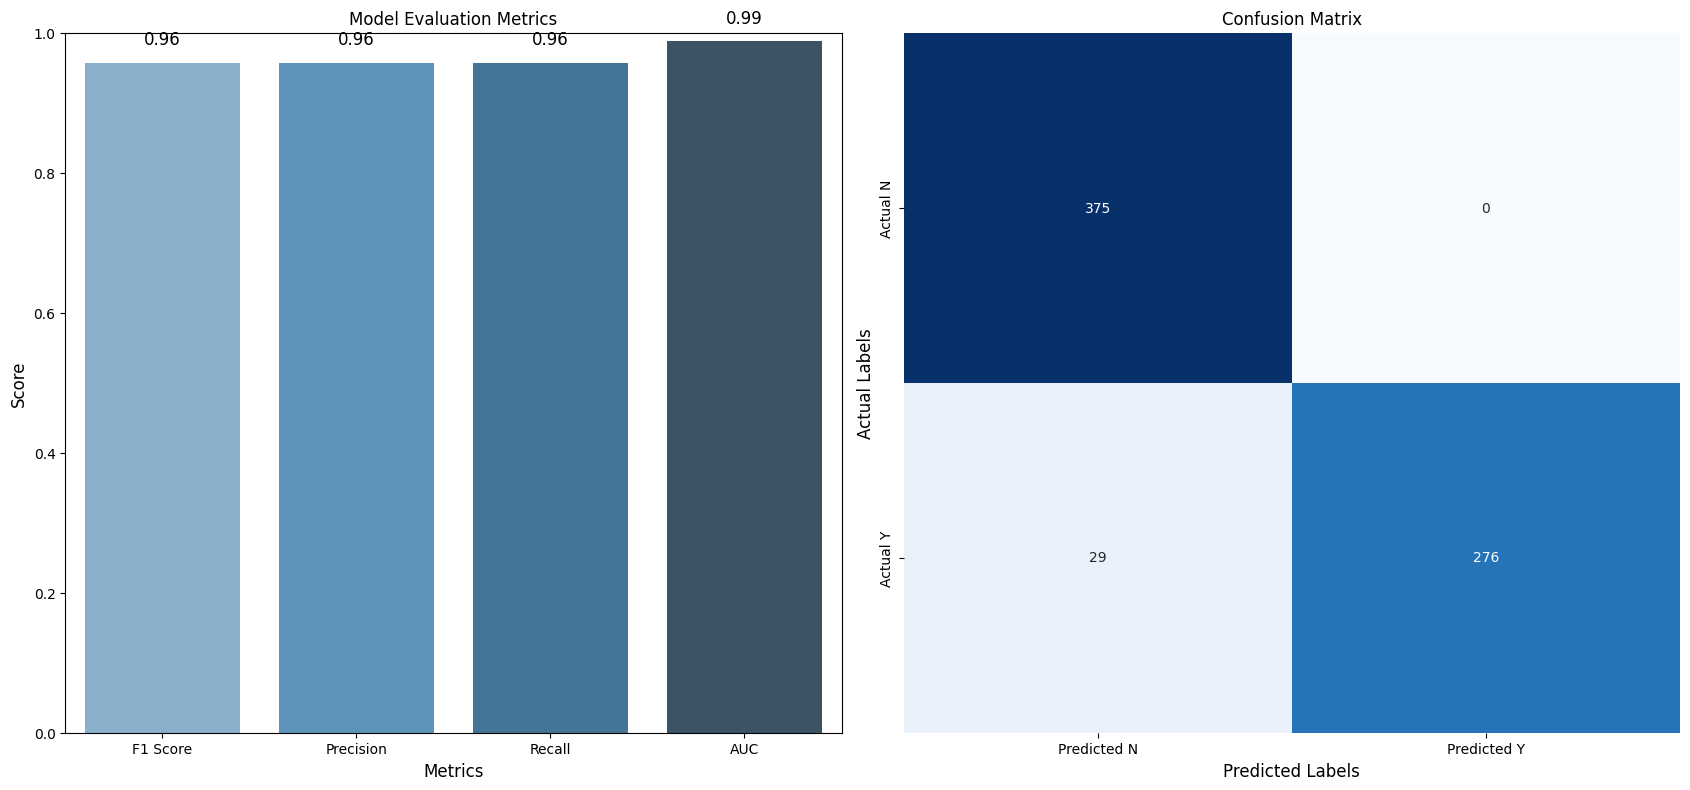

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_evaluation_results(metrics):
    """
    This function takes a dictionary of evaluation metrics and generates a professional plot
    that includes a bar plot for F1, Precision, Recall, AUC, and a heatmap for the confusion matrix.

    :param metrics: A dictionary containing 'Micro-F1', 'AUC', 'Precision', 'Recall', and 'Confusion Matrix'
    """
    # Extract metrics
    f1 = metrics['Micro-F1']
    auc = metrics['AUC']
    precision = metrics['Precision']
    recall = metrics['Recall']
    cm = metrics['Confusion Matrix']
    
    # Create a figure with two subplots: one for the bar plot, one for the confusion matrix
    fig, ax = plt.subplots(1, 2, figsize=(17, 8))
    
    # Create the bar plot for F1, Precision, Recall, and AUC
    bar_labels = ['F1 Score', 'Precision', 'Recall', 'AUC']
    bar_values = [f1, precision, recall, auc]
    
    sns.barplot(x=bar_labels, y=bar_values, ax=ax[0], palette='Blues_d')
    ax[0].set_ylim(0, 1)  # Set y-axis limit between 0 and 1
    ax[0].set_title("Model Evaluation Metrics", fontsize=12)
    ax[0].set_ylabel("Score", fontsize=12)
    ax[0].set_xlabel("Metrics", fontsize=12)

    # Annotate the bar plot with the exact values
    for idx, value in enumerate(bar_values):
        ax[0].text(idx, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12)

    # Create the heatmap for the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[1], cbar=False,
                xticklabels=cm.columns, yticklabels=cm.index)
    ax[1].set_title("Confusion Matrix", fontsize=12)
    ax[1].set_xlabel("Predicted Labels", fontsize=12)
    ax[1].set_ylabel("Actual Labels", fontsize=12)

    # Adjust layout for aesthetics
    plt.tight_layout()
    
    # Display the plot
    plt.show()



plot_evaluation_results(metrics)

## References

**Zhang, Hengrui, et al.** "Mixed-type tabular data synthesis with score-based diffusion in latent space." *International Conference on Learning Representations (ICLR)* (2023).

**GitHub Repository:** [Amazon Science - Tabsyn](https://github.com/amazon-science/tabsyn)